In [ ]:
# Read Data from google drive
from google.colab import drive #for loading gdrive data
from google.colab import files

# Load data from google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc
import csv
from google.colab.patches import cv2_imshow
from pathlib import Path


# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5
# import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image arra
# imports needed for dbtex function
print('---dbtex installs---')
!pip3 install -q pylibjpeg  #for dbtex
!pip3 install -q python-gdcm
!pip3 install -q pylibjpeg-libjpeg 
!pip3 install -q pylibjpeg-openjpeg
!pip3 install -q Pillow
import PIL
import pylibjpeg


     |████████████████████████████████| 1.9MB 8.8MB/s 
     |████████████████████████████████| 133kB 8.0MB/s 
---dbtex installs---
     |████████████████████████████████| 890kB 8.9MB/s 
     |████████████████████████████████| 3.6MB 28.8MB/s 
     |████████████████████████████████| 9.4MB 6.3MB/s 
     |████████████████████████████████| 4.2MB 7.5MB/s 


In [ ]:
# code borrowed from
#https://gist.github.com/cmarasinou/7c990a4835e80874b4de5f2433612d65
###############testing out embedded function, as .py import failing

from typing import AnyStr, BinaryIO, Optional, Union
import numpy as np
import pydicom as dicom
from skimage.exposure import rescale_intensity

def dcmread_image(
    fp: Union[str, "os.PathLike[AnyStr]", BinaryIO],
    view: str,
    index: Optional[np.uint] = None,
) -> np.ndarray:
    """Read pixel array from DBT DICOM file"""
    ds = dicom.dcmread(fp)
    ds.decompress(handler_name='pillow') #pylibjpeg')
    pixel_array = ds.pixel_array
    view_laterality = view[0].upper()
    image_laterality = _get_image_laterality(pixel_array[index or 0])
    if index is not None:
        pixel_array = pixel_array[index]
    if not image_laterality == view_laterality:
        pixel_array = np.flip(pixel_array, axis=(-1, -2))
        print("Laterality fixed!")
    window_center = _get_window_center(ds)
    window_width = _get_window_width(ds)
    low = (2 * window_center - window_width) / 2
    high = (2 * window_center + window_width) / 2
    pixel_array = rescale_intensity(
        pixel_array, in_range=(low, high), out_range="dtype"
    )
    return pixel_array

def _get_dicom_laterality(ds: dicom.dataset.FileDataset) -> str:
    """Unreliable - DICOM laterality is incorrect for some cases"""
    return ds[0x5200, 0x9229][0][0x0020, 0x9071][0][0x0020, 0x9072].value

def _get_image_laterality(pixel_array: np.ndarray) -> str:
    left_edge = np.sum(pixel_array[:, 0])  # sum of left edge pixels
    right_edge = np.sum(pixel_array[:, -1])  # sum of right edge pixels
    return "R" if left_edge < right_edge else "L"

def _get_window_center(ds: dicom.dataset.FileDataset) -> np.float32:
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1050].value)

def _get_window_width(ds: dicom.dataset.FileDataset) -> np.float32:
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1051].value)

In [ ]:
### set up drives for including .py files
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'UCLA_Courses/BE 223C Programming Lab Spring 2021'
GOOGLE_DRIVE_PATH = os.path.join('/content/gdrive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time
os.environ["TZ"] = "US/Eastern"
time.tzset()

['sample_code.ipynb', 'TrainYOLO.ipynb', 'DBT_DATA', 'Optimization.gslides', 'duke_dbt_data.py', '__pycache__', 'PNG_IMAGES', 'ReadinData.ipynb', 'YOLO', 'data', 'models', 'BE 223C Weekly Updates.gslides', 'apex', 'yolov5', 'cloth_example.ipynb']


In [ ]:
'''
GET DIR LISTING----------------------------------------------------------------
'''
def get_dirs(top_dir): 
    import os

    dir_list = os.scandir(top_dir)
    directories=[]
    patient_data = {}
    for ii in dir_list:
        print('top dir is ',ii)
        if (ii.is_dir()):
            #patient ID directory
            patient_id = ii.name
            patient_data[patient_id]={}
            directories.append(ii.name)
            #get file listings for each directory found
            full_name = os.path.join(top_dir,ii.name)

            files = os.scandir(full_name)
            for patient_uid in files:
                print('ptuid = ',patient_uid)

            if (patient_uid.is_dir()):
                #this will be the longer directory name
                #with study id
                #This will need to be tokenized to get 
                #the two fields out for info
                #--for now, keep the longer directory name
                patient_data[patient_id][patient_uid.name]={}

                exam_listings = os.scandir(os.path.join(full_name, 
                                                  patient_uid.name))
                for exam_number in exam_listings:
                    patient_data[patient_id][patient_uid.name][exam_number.name] =[]
                    #fill this in with exam dcm contents
                    dcm_list = os.listdir(os.path.join(full_name, 
                                                  patient_uid.name,
                                                  exam_number.name))
                    for dcm_file in dcm_list:
                        patient_data[patient_id][patient_uid.name][exam_number.name].append(dcm_file)

        else:
            print('*** found single file ',ii.name)
    
    return patient_data

In [ ]:
### Main level
top_dir = '/content/gdrive/My Drive/UCLA_Courses/BE 223C Programming Lab Spring 2021/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT'
#'/content/gdrive/My Drive/BE223C_SPRING_2021/IMAGE_ARRAY'

upper_dir = top_dir
patient_data = get_dirs(upper_dir)

top dir is  <DirEntry 'license.html'>
*** found single file  license.html
top dir is  <DirEntry 'DBT-P00013'>
ptuid =  <DirEntry '01-01-2000-DBT-S00163-MAMMO DIAGNOSTIC DIGITAL BILATERAL-56865'>
top dir is  <DirEntry 'DBT-P00064'>
ptuid =  <DirEntry '01-01-2000-DBT-S02651-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-15803'>
top dir is  <DirEntry 'DBT-P00052'>
ptuid =  <DirEntry '01-01-2000-DBT-S00420-MAMMO screening digital bilateral-82893'>
top dir is  <DirEntry 'DBT-P00023'>
ptuid =  <DirEntry '01-01-2000-DBT-S04378-MAMMO SCREENING DIGITAL BILATERAL-20650'>
top dir is  <DirEntry 'DBT-P00076'>
ptuid =  <DirEntry '01-01-2000-DBT-S00996-MAMMO screening digital bilateral-62986'>
top dir is  <DirEntry 'DBT-P00060'>
ptuid =  <DirEntry '01-01-2000-DBT-S00787-MAMMO diagnostic digital bilateral-48574'>
top dir is  <DirEntry 'DBT-P00024'>
ptuid =  <DirEntry '01-01-2000-DBT-S03255-MAMMO SCREENING DIGITAL BILATERAL-57165'>
top dir is  <DirEntry 'DBT-P00029'>
ptuid =  <DirEntry '01-01-2000-DBT-S00

In [ ]:
def get_csv_data(filename):
    fields = []
    rows = []
    # reading csv file
    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        # extracting field names through first row
        fields = next(csvreader)
        # extracting each data row one by one
        for row in csvreader:
            rows.append(row)
        # lines present
        print("found rows: %d"%(csvreader.line_num))
    return fields, rows

In [ ]:
#READ CSV FILES
csv_dir = '/content/gdrive/My Drive/UCLA_Courses/BE 223C Programming Lab Spring 2021/DBT_DATA/TRAINING_DATA/'
csv_list = os.listdir(csv_dir)

for csv_file in csv_list:
    filename = os.path.join(csv_dir,csv_file)
    if ('path' in csv_file):
        path_fields, path_rows = get_csv_data(filename)
    elif('labels' in csv_file):
        label_fields, label_rows = get_csv_data(filename)        
    elif('boxes' in csv_file):
        boxes_fields, boxes_rows = get_csv_data(filename)
    else:
        print('Non-archive file found ',filename)

print('box shape is ',np.shape(boxes_rows))

num_slices = np.double(np.array(boxes_rows)[:,[11]])
print('min slices, max slices = ',np.amin(num_slices), np.amax(num_slices))

found rows: 225
Non-archive file found  /content/gdrive/My Drive/UCLA_Courses/BE 223C Programming Lab Spring 2021/DBT_DATA/TRAINING_DATA/manifest-1605042674814
found rows: 2597
found rows: 2597
box shape is  (224, 12)
min slices, max slices =  24.0 114.0


In [ ]:
print(path_fields)
print(boxes_fields)

['PatientID', 'StudyUID', 'View', 'descriptive_path', 'classic_path']
['PatientID', 'StudyUID', 'View', 'Subject', 'Slice', 'X', 'Y', 'Width', 'Height', 'Class', 'AD', 'VolumeSlices']


In [ ]:
# Assign slices
for field_number,ii in enumerate(boxes_fields):
    if ('Slice' == ii):
        slice_column = field_number
    elif('View' == ii):
        view_column = field_number
for field_number, ii in enumerate(path_fields):
    if('descriptive_path' == ii):
        view_id_column = field_number
    elif('View' == ii):
        path_view_column = field_number
    elif('StudyUID' == ii):
        path_studyuid_column = field_number

# print('slice/view/viewid column is ', slice_column, view_column, view_id_column)
np.double(np.array(boxes_rows)[:,4])

# Assign view 
path_rows[0]

['DBT-P00013',
 'DBT-S00163',
 'rmlo',
 'Breast-Cancer-Screening-DBT/DBT-P00013/01-01-2000-DBT-S00163-MAMMO DIAGNOSTIC DIGITAL BILATERAL-56865/20566.000000-32081/1-1.dcm',
 'Breast-Cancer-Screening-DBT/DBT-P00013/1.2.826.0.1.3680043.8.498.97194784071397240980122342729639556865/1.2.826.0.1.3680043.8.498.97979602815077649368346148322369132081/1-1.dcm']

In [ ]:
boxes_rows[0]

['DBT-P00013',
 'DBT-S00163',
 'rmlo',
 '0',
 '16',
 '1116',
 '1724',
 '218',
 '105',
 'benign',
 '0',
 '49']

In [ ]:
#############MAPPING VIEW NUMBER TO VIEW TYPE
#Create smaller matrix used just for matching view number and name
#
view_map = [sublist[:4] for sublist in path_rows]

def match_view(view_number, view_map):
    #take the input view_number and match it to the text view name
    #search the smaller subset of path_rows to find the input number. The number
    #is locked into a full path, so we just do a text match to find the right
    #row
    for view_directory in view_map:
        if (str(view_number) in view_directory[3]):
            view_out = view_directory[2]

    return view_out

In [ ]:
def get_bounding_box(patient_id, patient_uid,view_type, boxes_rows):
    #get the corners of the annotated box
    #slice, x,y,width, height
    box_info = []
    for ii in boxes_rows:
        if (patient_id in ii[0]):
            if (view_type in ii[2]):# and (patient_uid in ii[1]):
                print('found box data')
                box_info.append(ii[4:10])
                break
    if(len(box_info) < 1):
        ## CHECK TO SEE IF THIS IS CANCER OR HAS A BOX. CLEAR CASES WON'T HAVE BOXES
        print('!!!!!! WARNING. BOUNDING BOXES EMPTY')
        print(patient_id, patient_uid, view_type)
    return box_info

In [ ]:
### Get the cancer labels assigned to this image
session = [sublist[1] for sublist in label_rows]

def get_cancer_label(studyuid_in,view_in,label_rows):
    #studyuid with view can be used together
    text_tokens = studyuid_in.split(sep='-')
    #format should be MM-DD-YYYY-DBT-S#####-~
    study_id = text_tokens[3] + '-' + text_tokens[4]
    print(study_id)

    #find matching study id and get labels from that row
    for ii in label_rows:
        if (study_id in ii[1]):
            #found a match -- could use a more efficient search here
            cancer_options = ii[3:]
            break
    
    if (cancer_options[0] == '1'):
        cancer_label = 'Normal'
    elif (cancer_options[1] == '1'):
        cancer_label = 'Actionable'
    elif (cancer_options[2] == '1'):
        cancer_label = 'Benign'
    elif (cancer_options[3] == '1'):
        cancer_label = 'Cancer'
    else:
        print('!!!!! WARNING!!!! No Valid cancer label retrieved')
        cancer_label = 'None'
    
    return study_id, cancer_label

In [ ]:
# Read a sample image
patient_id = 'DBT-P00024'
patient_uid = '01-01-2000-DBT-S03255-MAMMO SCREENING DIGITAL BILATERAL-57165'
view_number = '14782.000000-91029'

In [ ]:
png_dir = '/content/gdrive/My Drive/UCLA_Courses/New/PNG_IMAGES'
png_annotation_dir = '/content/gdrive/My Drive/UCLA_Courses/New/PNG_ANNOTATION_IMAGES'

In [ ]:
def normalize_coordinates(row_i, col_j, width, length, img):
    num_rows, num_cols = img.shape[:2]
    x = (row_i + width/2)/num_cols
    y = (col_j + length/2)/num_rows
    width_norm = width/num_cols
    length_norm = length/num_rows
    return x, y, width_norm, length_norm

In [ ]:
# Split train-val on the patient level
np.random.seed(945)
patient_lst = []
rep_cnt = 0
for row in boxes_rows:
  patient_id = row[0]
  if patient_id in patient_lst:
    rep_cnt += 1
  else:
    patient_lst.append(patient_id)
print(len(patient_lst))
from sklearn.model_selection import train_test_split
# trainval_patient, test_patient = train_test_split(patient_lst, test_size = 0.1)
train_patient, val_patient = train_test_split(patient_lst, test_size = 0.1)
len(train_patient), len(val_patient)

101


(90, 11)

In [ ]:
def create_dataset(patient_lst, dataset_type):
    images_path = Path(f'/content/gdrive/My Drive/UCLA_Courses/YOLO/images/{dataset_type}')
    images_path.mkdir(parents = True, exist_ok = True)

    labels_path = Path(f'/content/gdrive/My Drive/UCLA_Courses/YOLO/labels/{dataset_type}')
    labels_path.mkdir(parents = True, exist_ok = True)
    for patient_id in patient_lst:
      # do a pre-check to see if this has a bounding box
      for patient_uid in patient_data[patient_id].keys():
        for view_number in patient_data[patient_id][patient_uid].keys():
          for dcm_file in patient_data[patient_id][patient_uid][view_number]:
            # convert the views to the type used in the box csv file
            view_type = match_view(view_number, view_map)
            box_info = get_bounding_box(patient_id, patient_uid, view_type, boxes_rows)
            dcm_full_file = os.path.join(upper_dir, patient_id, patient_uid, view_number, dcm_file)
            print(dcm_full_file)
            # we will only print out the slices that have bounding boxes
            number_matching_slices = np.shape(box_info)[0] #------NEEDS CHECKS
            if (number_matching_slices < 1):
              print('!! no bounding box !!') #!! slice counting issue or no bounding box. skipping')
              print('---->',number_matching_slices, patient_id, view_type,box_info)
            else:
              dcm_full_file = os.path.join(upper_dir,patient_id, patient_uid, view_number, dcm_file)
              img_data = dcmread_image(dcm_full_file, view_type) #'0')
              for slices in range(0, number_matching_slices):
                slice_number = int(box_info[slices][0])
                print('Opening slice sequence #: ', slices, slice_number)
                # Make png
                plt.imshow(img_data[slice_number,:,:], cmap = plt.cm.bone)
                plt.axis('off')
                # Get annotations box
                xcorner = int(box_info[slices][1])
                ycorner = int(box_info[slices][2])
                xwidth = int(box_info[slices][3])
                yheight = int(box_info[slices][4])
                boxlabel = box_info[slices][5]

                image_name = str(patient_id) + '_' + str(view_type) + '_sequence' + str(slices) + 'slice_' + str(slice_number) + '.png'
                save_filename = os.path.join(images_path, image_name)
                plt.savefig(save_filename, dpi = 1200, bbox_inches = 'tight', pad_inches = 0)

                label_name = str(patient_id) + '_' + str(view_type) + '_sequence' + str(slices) + 'slice_' + str(slice_number) + '.txt'
                with (labels_path / label_name).open(mode = 'w') as label_file:
                  if boxlabel == 'benign':
                    category_idx = 0
                  elif boxlabel == 'cancer':
                    category_idx = 1
                  
                  x, y, bbox_width, bbox_height = normalize_coordinates(xcorner, ycorner, xwidth, yheight, img_data[slice_number,:,:])
                  label_file.write(
                      f"{category_idx} {x} {y} {bbox_width} {bbox_height} \n"
                  )
                time.sleep(0.5)
                # plt.show()
                plt.cla()
                plt.clf()
              del img_data    #  img_data = None
              gc.collect() #collect garbage

In [ ]:
create_dataset(val_patient, 'val')

found box data
/content/gdrive/My Drive/UCLA_Courses/BE 223C Programming Lab Spring 2021/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P03203/01-01-2000-DBT-S04862-MAMMO diagnostic digital bilateral-92733/14304.000000-59631/1-1.dcm


/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


Opening slice sequence #:  0 22
found box data
/content/gdrive/My Drive/UCLA_Courses/BE 223C Programming Lab Spring 2021/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P03203/01-01-2000-DBT-S04862-MAMMO diagnostic digital bilateral-92733/14305.000000-63473/1-1.dcm
Opening slice sequence #:  0 38
found box data
/content/gdrive/My Drive/UCLA_Courses/BE 223C Programming Lab Spring 2021/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P01112/01-01-2000-DBT-S04216-MAMMO SCREENING BREAST TOMOSYNTHESIS-55399/709.000000-85307/1-1.dcm
Opening slice sequence #:  0 35
found box data
/content/gdrive/My Drive/UCLA_Courses/BE 223C Programming Lab Spring 2021/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P01112/01-01-2000-DBT-S04216-MAMMO SCREENING BREAST TOMOSYNTHESIS-55399/710.000000-65963/1-1.dcm
Opening slice sequence #:  0 33
found box data
/content/gdrive/My Drive/UCLA_Courses/BE 223C Programming Lab Spr

<Figure size 432x288 with 0 Axes>

In [ ]:
create_dataset(train_patient, 'train')

found box data
/content/gdrive/My Drive/UCLA_Courses/BE 223C Programming Lab Spring 2021/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P01439/01-01-2000-DBT-S01096-MAMMO SCREENING BREAST TOMOSYNTHESIS-85652/5189.000000-33192/1-1.dcm


/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


Opening slice sequence #:  0 37
found box data
/content/gdrive/My Drive/UCLA_Courses/BE 223C Programming Lab Spring 2021/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P01817/01-01-2000-DBT-S01841-MAMMO diagnostic digital bilateral-51322/8610.000000-57707/1-1.dcm
Opening slice sequence #:  0 20
found box data
/content/gdrive/My Drive/UCLA_Courses/BE 223C Programming Lab Spring 2021/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P01817/01-01-2000-DBT-S01841-MAMMO diagnostic digital bilateral-51322/8611.000000-33236/1-1.dcm
Opening slice sequence #:  0 38
found box data
/content/gdrive/My Drive/UCLA_Courses/BE 223C Programming Lab Spring 2021/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P01461/01-01-2000-DBT-S00251-MAMMO SCREENING DIGITAL BILATERAL-51291/20284.000000-24547/1-1.dcm
Laterality fixed!
Opening slice sequence #:  0 23
found box data
/content/gdrive/My Drive/UCLA_Courses/BE 223C Prog

<Figure size 432x288 with 0 Axes>

In [ ]:
## Normal codes end here ##

found box data
/content/gdrive/My Drive/UCLA_Courses/BE 223C Programming Lab Spring 2021/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00024/01-01-2000-DBT-S03255-MAMMO SCREENING DIGITAL BILATERAL-57165/14782.000000-91029/1-1.dcm


/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


Laterality fixed!
Opening slice sequence#:  0 19
0.1497995991983968 0.21164021164021163 0.03206412825651302 0.026048026048026047


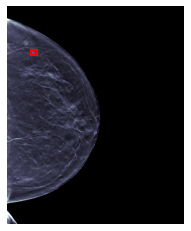

<Figure size 432x288 with 0 Axes>

In [ ]:
# To create single file (need to specify patient id, uid, and view number)
for dcm_file in patient_data[patient_id][patient_uid][view_number]:

  #convert the views to the type used in the box csv file
  view_type = match_view(view_number, view_map)

  box_info = get_bounding_box(patient_id, patient_uid, view_type, boxes_rows)
  dcm_full_file = os.path.join(upper_dir, patient_id, patient_uid, view_number, dcm_file)
  print(dcm_full_file)
  #img_data = dcmread_image(dcm_full_file,'0')
                    
  #we will only print out the slices that have bounding boxes
  number_matching_slices = np.shape(box_info)[0] #------NEEDS CHECKS
  if (number_matching_slices < 1):
    print('!! no bounding box !!') #!! slice counting issue or no bounding box. skipping')
    print('---->',number_matching_slices, patient_id, view_type,box_info)
  else:
    dcm_full_file = os.path.join(upper_dir,patient_id, patient_uid, view_number, dcm_file)
    img_data = dcmread_image(dcm_full_file,view_type) #'0')

    for slices in range(0, number_matching_slices):
      slice_number = int(box_info[slices][0])
      print('Opening slice sequence#: ', slices, slice_number)
      # Make png
      plt.imshow(img_data[slice_number,:,:], cmap=plt.cm.bone)
      plt.axis('off')
      #### Draw annotation box
      xcorner = int(box_info[slices][1])
      ycorner = int(box_info[slices][2])
      xwidth = int(box_info[slices][3])
      yheight = int(box_info[slices][4])
      rect = patches.Rectangle((xcorner,ycorner), xwidth, yheight, linewidth=2, edgecolor='r', facecolor='none')
      x, y, bbox_width, bbox_height = normalize_coordinates(xcorner, ycorner, xwidth, yheight, img_data[slice_number,:,:])
      print(x, y, bbox_width, bbox_height)
      # # Get the current reference
      ax = plt.gca()
      # print(ax)
      # # Add the patch to the Axes
      ax.add_patch(rect)
      # 
      ###

      fname = str(patient_id) + '_' + str(view_type) + '_sequence' + str(slices) + 'slice_' + str(slice_number) + '.png'
      save_filename = os.path.join(png_dir, fname)
      plt.savefig(save_filename, dpi = 1200, bbox_inches='tight',pad_inches = 0)
      plt.show()
      time.sleep(0.5)
      plt.cla()
      plt.clf()
    # del img_data    #  img_data = None
    # gc.collect() #collect garbage
                    
            